In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.zip', 'sampleSubmission.csv.zip', 'train_cleaned.zip', 'test.zip']


In [16]:
!pip install python-resize-image

You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import os

print(os.listdir("/kaggle/input"))

['train.zip', 'sampleSubmission.csv.zip', 'train_cleaned.zip', 'test.zip']


In [18]:
import zipfile
import os

def unzip(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip(
    "/kaggle/input/train.zip",
    "/kaggle/working/train"
)

unzip(
    "/kaggle/input/test.zip",
    "/kaggle/working/test"
)

unzip(
    "/kaggle/input/train_cleaned.zip",
    "/kaggle/working/train_cleaned"
)

In [19]:
import cv2
import os
import numpy as np
from PIL import Image
from resizeimage import resizeimage

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename == "train":
            continue
        if filename == "test":
            continue
        if filename == "train_cleaned":
            continue
        img = cv2.imread(os.path.join(folder,filename))
        img = np.array(img)
        s = img.shape
        s = np.array(s)
        if  s[0] == 258:
            img1 = Image.open(os.path.join(folder,filename))
            new1 = resizeimage.resize_contain(img1, [540, 420, 3])
            new1 = np.array(new1, dtype='uint8')
            images.append(new1)
        else:
            img1 = Image.open(os.path.join(folder,filename))
            images.append(img)
    return images

train = load_images_from_folder("/kaggle/working/train/train")
test = load_images_from_folder("/kaggle/working/test/test")
train_cleaned = load_images_from_folder("/kaggle/working/train_cleaned/train_cleaned")

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms

In [21]:
# ==================== DATA PREPROCESSING ====================

class ImagePreprocessor:
    """Handles all preprocessing steps for image denoising"""
    
    def __init__(self, target_size=(256, 256)):
        self.target_size = target_size
        
    def normalize_image(self, img):
        """Normalize image to [0, 1] range"""
        return img.astype(np.float32) / 255.0
    
    def denormalize_image(self, img):
        """Convert back to [0, 255] range"""
        return (img * 255.0).astype(np.uint8)
    
    def resize_image(self, img):
        """Resize image maintaining aspect ratio"""
        return cv2.resize(img, self.target_size, interpolation=cv2.INTER_AREA)
    
    def augment_image(self, img):
        """Apply random augmentation for training"""
        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = cv2.flip(img, 1)
        
        # Random vertical flip
        if np.random.rand() > 0.5:
            img = cv2.flip(img, 0)
        
        # Random rotation (90, 180, 270 degrees)
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k)
        
        return img
    
    def add_noise_visualization(self, clean_img, noise_level=25):
        """Add Gaussian noise for visualization purposes"""
        noise = np.random.normal(0, noise_level, clean_img.shape)
        noisy = np.clip(clean_img + noise, 0, 255).astype(np.uint8)
        return noisy

In [22]:
class DenoisingDataset(Dataset):
    """Custom dataset for image denoising"""
    
    def __init__(self, noisy_images, clean_images, preprocessor, augment=False):
        self.noisy_images = noisy_images
        self.clean_images = clean_images
        self.preprocessor = preprocessor
        self.augment = augment
        
    def __len__(self):
        return len(self.noisy_images)
    
    def __getitem__(self, idx):
        noisy = self.noisy_images[idx].copy()
        clean = self.clean_images[idx].copy()
        
        # Convert RGBA to RGB if needed (4 channels -> 3 channels)
        if noisy.shape[2] == 4:
            noisy = cv2.cvtColor(noisy, cv2.COLOR_RGBA2RGB)
        if clean.shape[2] == 4:
            clean = cv2.cvtColor(clean, cv2.COLOR_RGBA2RGB)
        
        # Resize
        noisy = self.preprocessor.resize_image(noisy)
        clean = self.preprocessor.resize_image(clean)
        
        # Augment (apply same transform to both)
        if self.augment:
            seed = np.random.randint(0, 2**32)
            np.random.seed(seed)
            noisy = self.preprocessor.augment_image(noisy)
            np.random.seed(seed)
            clean = self.preprocessor.augment_image(clean)
        
        # Normalize
        noisy = self.preprocessor.normalize_image(noisy)
        clean = self.preprocessor.normalize_image(clean)
        
        # Convert to tensor (H, W, C) -> (C, H, W)
        noisy = torch.from_numpy(noisy.transpose(2, 0, 1))
        clean = torch.from_numpy(clean.transpose(2, 0, 1))
        
        return noisy, clean

In [23]:

# ==================== AUTOENCODER ARCHITECTURE ====================

class ConvBlock(nn.Module):
    """Basic convolutional block with BatchNorm and activation"""
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class Encoder(nn.Module):
    """Encoder: progressively downsamples and increases channels"""
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        # Level 1: [8, 3, 256, 256] -> [8, 64, 256, 256] -> [8, 64, 128, 128]
        self.enc1_1 = ConvBlock(3, 64)
        self.enc1_2 = ConvBlock(64, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Level 2: [8, 64, 128, 128] -> [8, 64, 128, 128] -> [8, 128, 64, 64]
        self.enc2_1 = ConvBlock(64, 128)
        self.enc2_2 = ConvBlock(128, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Level 3: [8, 128, 64, 64] -> [8, 256, 64, 64] -> [8, 256, 32, 32]
        self.enc3_1 = ConvBlock(128, 256)
        self.enc3_2 = ConvBlock(256, 256)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Level 4: [8, 256, 32, 32] -> [8, 512, 32, 32] -> [8, 512, 16, 16]
        self.enc4_1 = ConvBlock(256, 512)
        self.enc4_2 = ConvBlock(512, 512)
        self.pool4 = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        # Store skip connections for potential use
        e1 = self.enc1_2(self.enc1_1(x))
        p1 = self.pool1(e1)
        
        e2 = self.enc2_2(self.enc2_1(p1))
        p2 = self.pool2(e2)
        
        e3 = self.enc3_2(self.enc3_1(p2))
        p3 = self.pool3(e3)
        
        
        e4 = self.enc4_2(self.enc4_1(p3))
        p4 = self.pool4(e4)

        print("Encoder:\n")
        print(e1.shape)
        print(p1.shape)
        print(e2.shape)
        print(p2.shape)
        print(e3.shape)
        print(p3.shape)
        print(e4.shape)
        print(p4.shape)
        
        return p4, [e1, e2, e3, e4]  # Return bottleneck and skip connections


class Decoder(nn.Module):
    """Decoder: progressively upsamples and decreases channels"""
    
    def __init__(self, use_skip_connections=False):
        super(Decoder, self).__init__()
        self.use_skip_connections = use_skip_connections
        
        # Bottleneck: 16x16x512
        self.bottleneck = nn.Sequential(
            ConvBlock(512, 512),
            ConvBlock(512, 512)
        )
        
        # Level 4: 16x16x512 -> 32x32x256
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        mult = 2 if use_skip_connections else 1
        self.dec4_1 = ConvBlock(256 * mult, 256)
        self.dec4_2 = ConvBlock(256, 256)
        
        # Level 3: 32x32x256 -> 64x64x128
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3_1 = ConvBlock(128 * mult, 128)
        self.dec3_2 = ConvBlock(128, 128)
        
        # Level 2: 64x64x128 -> 128x128x64
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2_1 = ConvBlock(64 * mult, 64)
        self.dec2_2 = ConvBlock(64, 64)
        
        # Level 1: 128x128x64 -> 256x256x64
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1_1 = ConvBlock(64 * mult, 64)
        self.dec1_2 = ConvBlock(64, 64)
        
        # Final output: 256x256x3
        self.final = nn.Conv2d(64, 3, kernel_size=1)
        
    def forward(self, x, skip_connections):
        e1, e2, e3, e4 = skip_connections
        print("Decoder:\n")
        print(e1.shape)
        print(e2.shape)
        print(e3.shape)
        print(e4.shape)
        
        # Bottleneck
        b = self.bottleneck(x)
        
        # Decode with skip connections
        d4 = self.up4(b)
        if self.use_skip_connections:
            d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4_2(self.dec4_1(d4))
        
        d3 = self.up3(d4)
        if self.use_skip_connections:
            d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3_2(self.dec3_1(d3))
        
        d2 = self.up2(d3)
        if self.use_skip_connections:
            d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2_2(self.dec2_1(d2))
        
        d1 = self.up1(d2)
        if self.use_skip_connections:
            d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1_2(self.dec1_1(d1))
        
        # Final output with sigmoid to ensure [0, 1] range
        out = torch.sigmoid(self.final(d1))
        print(d1.shape)
        print(d2.shape)
        print(d3.shape)
        print(d4.shape)
        print(out.shape)
        
        return out

In [24]:
class DenoisingAutoencoder(nn.Module):
    """Complete autoencoder for image denoising"""
    
    def __init__(self, use_skip_connections=False):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(use_skip_connections)
        
    def forward(self, x):
        bottleneck, skip_connections = self.encoder(x)
        output = self.decoder(bottleneck, skip_connections)
        return output

In [25]:
# ==================== LOSS FUNCTIONS ====================

class CombinedLoss(nn.Module):
    """Combines MSE and perceptual-like loss for better quality"""
    
    def __init__(self, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha  # Weight for MSE
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()
        
    def forward(self, output, target):
        mse_loss = self.mse(output, target)
        l1_loss = self.l1(output, target)
        return self.alpha * mse_loss + (1 - self.alpha) * l1_loss

In [26]:
# ==================== TRAINING UTILITIES ====================

class Trainer:
    """Handles training, validation, and visualization"""
    
    def __init__(self, model, device, learning_rate=1e-3, weight_decay=1e-5):
        self.model = model.to(device)
        self.device = device
        self.criterion = CombinedLoss(alpha=0.8)
        
        # Optimizer with weight decay for regularization
        try:
            self.optimizer = optim.AdamW(
                model.parameters(), 
                lr=learning_rate, 
                weight_decay=weight_decay
            )
            print("Using AdamW optimizer")
        except AttributeError:
            self.optimizer = optim.Adam(
                model.parameters(), 
                lr=learning_rate, 
                weight_decay=weight_decay
            )
            print("Using Adam optimizer (AdamW not available)")
        
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        
    def setup_scheduler(self, train_loader, epochs, min_lr=1e-6):
        """Setup cosine annealing scheduler"""
        steps_per_epoch = len(train_loader)
        total_steps = epochs * steps_per_epoch
        
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=total_steps,
            eta_min=min_lr
        )
        
    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0.0
        
        pbar = tqdm(train_loader, desc="Training")
        for noisy, clean in pbar:
            noisy = noisy.to(self.device)
            clean = clean.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(noisy)
            loss = self.criterion(output, clean)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            self.scheduler.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        return epoch_loss / len(train_loader)
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for noisy, clean in tqdm(val_loader, desc="Validation"):
                noisy = noisy.to(self.device)
                clean = clean.to(self.device)
                
                output = self.model(noisy)
                loss = self.criterion(output, clean)
                val_loss += loss.item()
        
        return val_loss / len(val_loader)
    
    def train(self, train_loader, val_loader, epochs, save_path='best_model.pth'):
        """Full training loop"""
        self.setup_scheduler(train_loader, epochs)
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            
            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self .model.state_dict(), save_path)
                print(f"Model saved with val_loss: {val_loss:.4f}")
    
    def plot_training_history(self):
        """Visualize training progress"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def visualize_results(self, dataloader, num_samples=5):
        """Visualize denoising results"""
        self.model.eval()
        
        samples = []
        with torch.no_grad():
            for noisy, clean in dataloader:
                noisy = noisy.to(self.device)
                clean = clean.to(self.device)
                output = self.model(noisy)
                
                samples.append((noisy.cpu(), output.cpu(), clean.cpu()))
                if len(samples) >= num_samples:
                    break
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
        for i, (noisy, output, clean) in enumerate(samples):
            # Convert from tensor to numpy for visualization
            noisy_img = noisy[0].permute(1, 2, 0).numpy()
            output_img = output[0].permute(1, 2, 0).numpy()
            clean_img = clean[0].permute(1, 2, 0).numpy()
            
            axes[i, 0].imshow(noisy_img)
            axes[i, 0].set_title('Noisy Input')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(output_img)
            axes[i, 1].set_title('Denoised Output')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(clean_img)
            axes[i, 2].set_title('Clean Target')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Using device: cuda
Total parameters: 11,741,187
Using Adam optimizer (AdamW not available)

Epoch 1/50
Learning Rate: 0.001000
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:11,  1.22it/s, loss=0.2349]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:08,  1.47it/s, loss=0.2317]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:07,  1.71it/s, loss=0.2217]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  1.94it/s, loss=0.2172]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.13it/s, loss=0.2096]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.2055]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.42it/s, loss=0.1955]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.52it/s, loss=0.1945]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.60it/s, loss=0.1901]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:01,  2.66it/s, loss=0.1894]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.69it/s, loss=0.1868]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.71it/s, loss=0.1811]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.73it/s, loss=0.1776]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.34it/s, loss=0.1804]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.1994 | Val Loss: 0.2189
Model saved with val_loss: 0.2189

Epoch 2/50
Learning Rate: 0.000999
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 


Training:   7%|▋         | 1/15 [00:00<00:08,  1.62it/s, loss=0.1691]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:00<00:07,  1.85it/s, loss=0.1705]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:05,  2.07it/s, loss=0.1676]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:04,  2.24it/s, loss=0.1654]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.37it/s, loss=0.1611]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.48it/s, loss=0.1613]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.57it/s, loss=0.1578]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.63it/s, loss=0.1552]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.67it/s, loss=0.1504]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:03<00:01,  2.69it/s, loss=0.1498]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.71it/s, loss=0.1501]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.72it/s, loss=0.1477]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:04<00:00,  2.72it/s, loss=0.1475]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.32it/s, loss=0.1399]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.1556 | Val Loss: 0.1655
Model saved with val_loss: 0.1655

Epoch 3/50
Learning Rate: 0.000996


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.64it/s, loss=0.1363]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:00<00:06,  1.86it/s, loss=0.1394]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:05,  2.07it/s, loss=0.1321]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:04,  2.23it/s, loss=0.1311]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.37it/s, loss=0.1306]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.47it/s, loss=0.1295]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.54it/s, loss=0.1254]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.60it/s, loss=0.1234]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.64it/s, loss=0.1249]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:03<00:01,  2.67it/s, loss=0.1219]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.68it/s, loss=0.1157]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.69it/s, loss=0.1220]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:04<00:00,  2.71it/s, loss=0.1164]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.30it/s, loss=0.1138]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.1251 | Val Loss: 0.1157



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Model saved with val_loss: 0.1157

Epoch 4/50
Learning Rate: 0.000992
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.62it/s, loss=0.1063]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:00<00:07,  1.84it/s, loss=0.1120]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:05,  2.05it/s, loss=0.1071]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:04,  2.22it/s, loss=0.1083]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.34it/s, loss=0.1077]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.44it/s, loss=0.1093]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.53it/s, loss=0.1014]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.61it/s, loss=0.0977]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.64it/s, loss=0.0982]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:03<00:01,  2.66it/s, loss=0.1021]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.67it/s, loss=0.0984]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.68it/s, loss=0.0987]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.69it/s, loss=0.0961]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.26it/s, loss=0.0911]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.1020 | Val Loss: 0.0916



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Model saved with val_loss: 0.0916

Epoch 5/50
Learning Rate: 0.000985
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.51it/s, loss=0.0879]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.74it/s, loss=0.0920]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0917]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.13it/s, loss=0.0874]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.27it/s, loss=0.0957]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.38it/s, loss=0.0830]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.47it/s, loss=0.0854]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.54it/s, loss=0.0888]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.58it/s, loss=0.0901]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:03<00:01,  2.62it/s, loss=0.0847]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.64it/s, loss=0.0835]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.65it/s, loss=0.0814]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.66it/s, loss=0.0831]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.22it/s, loss=0.0811]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  25%|██▌       | 1/4 [00:00<00:01,  2.73it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.0863 | Val Loss: 0.0704
Model saved with val_loss: 0.0704

Epoch 6/50
Learning Rate: 0.000976
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 


Training:   7%|▋         | 1/15 [00:00<00:08,  1.59it/s, loss=0.0823]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.81it/s, loss=0.0767]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:05,  2.00it/s, loss=0.0712]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.17it/s, loss=0.0767]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.29it/s, loss=0.0836]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.39it/s, loss=0.0784]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.46it/s, loss=0.0822]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.52it/s, loss=0.0742]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.57it/s, loss=0.0762]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:01,  2.59it/s, loss=0.0759]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.61it/s, loss=0.0738]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.62it/s, loss=0.0740]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.63it/s, loss=0.0663]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.20it/s, loss=0.0770]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.0760 | Val Loss: 0.0709

Epoch 7/50
Learning Rate: 0.000966
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])


Training:   7%|▋         | 1/15 [00:00<00:08,  1.59it/s, loss=0.0677]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.81it/s, loss=0.0768]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:05,  2.00it/s, loss=0.0704]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.16it/s, loss=0.0703]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.30it/s, loss=0.0722]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.39it/s, loss=0.0627]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.47it/s, loss=0.0661]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.52it/s, loss=0.0695]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.55it/s, loss=0.0662]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:01,  2.57it/s, loss=0.0684]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.59it/s, loss=0.0645]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.59it/s, loss=0.0690]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.61it/s, loss=0.0594]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.17it/s, loss=0.0596]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.0669 | Val Loss: 0.0722

Epoch 8/50
Learning Rate: 0.000953
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])


Training:   7%|▋         | 1/15 [00:00<00:08,  1.58it/s, loss=0.0627]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.79it/s, loss=0.0634]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.98it/s, loss=0.0600]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.14it/s, loss=0.0632]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.26it/s, loss=0.0658]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.36it/s, loss=0.0619]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.44it/s, loss=0.0613]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.49it/s, loss=0.0647]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.52it/s, loss=0.0603]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:01,  2.54it/s, loss=0.0615]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.56it/s, loss=0.0648]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.57it/s, loss=0.0552]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.58it/s, loss=0.0583]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.14it/s, loss=0.0486]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.12it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.0604 | Val Loss: 0.0630



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Model saved with val_loss: 0.0630

Epoch 9/50
Learning Rate: 0.000939
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.52it/s, loss=0.0551]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.74it/s, loss=0.0604]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0533]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0566]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.22it/s, loss=0.0602]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.32it/s, loss=0.0534]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.40it/s, loss=0.0621]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.45it/s, loss=0.0559]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.49it/s, loss=0.0587]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:01,  2.52it/s, loss=0.0533]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.54it/s, loss=0.0548]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.55it/s, loss=0.0615]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.56it/s, loss=0.0499]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.11it/s, loss=0.0578]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0570 | Val Loss: 0.0676

Epoch 10/50
Learning Rate: 0.000923
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.61it/s, loss=0.0557]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.81it/s, loss=0.0599]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.99it/s, loss=0.0600]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.13it/s, loss=0.0561]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.26it/s, loss=0.0581]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.34it/s, loss=0.0552]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.40it/s, loss=0.0539]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s, loss=0.0544]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.47it/s, loss=0.0560]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0533]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0535]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.52it/s, loss=0.0524]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0542]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0544]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.03it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.90it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0554 | Val Loss: 0.0531
Model saved with val_loss: 0.0531

Epoch 11/50
Learning Rate: 0.000906
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.51it/s, loss=0.0496]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.72it/s, loss=0.0553]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.90it/s, loss=0.0542]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.06it/s, loss=0.0464]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.18it/s, loss=0.0494]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.28it/s, loss=0.0556]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.35it/s, loss=0.0486]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.40it/s, loss=0.0563]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0457]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.46it/s, loss=0.0510]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s, loss=0.0499]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:05<00:01,  2.50it/s, loss=0.0477]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.50it/s, loss=0.0561]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.03it/s, loss=0.0536]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.81it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0513 | Val Loss: 0.0536

Epoch 12/50
Learning Rate: 0.000887
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.49it/s, loss=0.0519]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.70it/s, loss=0.0470]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.88it/s, loss=0.0449]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.04it/s, loss=0.0539]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.15it/s, loss=0.0462]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:04,  2.25it/s, loss=0.0463]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.32it/s, loss=0.0525]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.37it/s, loss=0.0517]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.40it/s, loss=0.0539]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.43it/s, loss=0.0551]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.45it/s, loss=0.0476]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:05<00:01,  2.46it/s, loss=0.0488]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.46it/s, loss=0.0458]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:06<00:00,  2.99it/s, loss=0.0505]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0495 | Val Loss: 0.0537

Epoch 13/50
Learning Rate: 0.000866
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.52it/s, loss=0.0530]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.72it/s, loss=0.0622]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.89it/s, loss=0.0408]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.04it/s, loss=0.0411]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.15it/s, loss=0.0494]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:04,  2.24it/s, loss=0.0456]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.30it/s, loss=0.0489]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.35it/s, loss=0.0473]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.38it/s, loss=0.0481]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.40it/s, loss=0.0398]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.42it/s, loss=0.0513]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:05<00:01,  2.43it/s, loss=0.0497]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.44it/s, loss=0.0478]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:06<00:00,  2.98it/s, loss=0.0432]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0475 | Val Loss: 0.0507
Model saved with val_loss: 0.0507

Epoch 14/50
Learning Rate: 0.000844
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.50it/s, loss=0.0390]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.70it/s, loss=0.0515]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.87it/s, loss=0.0540]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.02it/s, loss=0.0458]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.14it/s, loss=0.0456]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:04,  2.23it/s, loss=0.0499]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.30it/s, loss=0.0446]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.35it/s, loss=0.0472]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.38it/s, loss=0.0555]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.40it/s, loss=0.0423]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.42it/s, loss=0.0489]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:05<00:01,  2.44it/s, loss=0.0380]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.44it/s, loss=0.0442]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:06<00:00,  2.95it/s, loss=0.0355]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.46it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.28it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0461 | Val Loss: 0.0502
Model saved with val_loss: 0.0502

Epoch 15/50
Learning Rate: 0.000821
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.53it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.73it/s, loss=0.0442]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.91it/s, loss=0.0484]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.06it/s, loss=0.0448]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.17it/s, loss=0.0424]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.26it/s, loss=0.0530]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.34it/s, loss=0.0456]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.39it/s, loss=0.0454]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.42it/s, loss=0.0447]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.45it/s, loss=0.0462]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.47it/s, loss=0.0454]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:05<00:01,  2.48it/s, loss=0.0482]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.49it/s, loss=0.0465]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:06<00:00,  3.02it/s, loss=0.0455]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0456 | Val Loss: 0.0477
Model saved with val_loss: 0.0477

Epoch 16/50
Learning Rate: 0.000796
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0476]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0482]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0441]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0441]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0444]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0409]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0408]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0440]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0478]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0405]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0460]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0445]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0377]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.72it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0441 | Val Loss: 0.0468
Model saved with val_loss: 0.0468

Epoch 17/50
Learning Rate: 0.000770
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0505]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0407]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0354]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0423]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0465]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.31it/s, loss=0.0368]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.38it/s, loss=0.0472]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0478]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0419]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0464]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0424]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.52it/s, loss=0.0441]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.53it/s, loss=0.0384]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0362]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.99it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.85it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0430 | Val Loss: 0.0469

Epoch 18/50
Learning Rate: 0.000743
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0395]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0436]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0409]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0485]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0479]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.31it/s, loss=0.0348]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.39it/s, loss=0.0452]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.45it/s, loss=0.0453]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.48it/s, loss=0.0458]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.50it/s, loss=0.0371]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.52it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.53it/s, loss=0.0454]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.54it/s, loss=0.0357]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.09it/s, loss=0.0376]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  5.01it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0422 | Val Loss: 0.0459
Model saved with val_loss: 0.0459

Epoch 19/50
Learning Rate: 0.000715
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0439]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0434]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0397]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.11it/s, loss=0.0449]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.22it/s, loss=0.0438]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0415]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.37it/s, loss=0.0420]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0447]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.47it/s, loss=0.0416]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:01,  2.50it/s, loss=0.0394]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.52it/s, loss=0.0428]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.53it/s, loss=0.0389]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.54it/s, loss=0.0452]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.09it/s, loss=0.0335]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0417 | Val Loss: 0.0461

Epoch 20/50
Learning Rate: 0.000686
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0448]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0475]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.96it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.11it/s, loss=0.0386]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.22it/s, loss=0.0380]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.32it/s, loss=0.0411]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.38it/s, loss=0.0459]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.43it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.47it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0456]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.51it/s, loss=0.0379]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.52it/s, loss=0.0438]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.53it/s, loss=0.0434]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.08it/s, loss=0.0374]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0414 | Val Loss: 0.0450
Model saved with val_loss: 0.0450

Epoch 21/50
Learning Rate: 0.000657
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0417]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0402]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0406]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.11it/s, loss=0.0447]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0427]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.31it/s, loss=0.0389]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.39it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s, loss=0.0468]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0372]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0384]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.51it/s, loss=0.0428]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.52it/s, loss=0.0435]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0407]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.85it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0411 | Val Loss: 0.0440
Model saved with val_loss: 0.0440

Epoch 22/50
Learning Rate: 0.000627
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0424]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0386]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0466]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0485]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0431]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.37it/s, loss=0.0330]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0415]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0444]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0409]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0390]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0331]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.05it/s, loss=0.0374]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0405 | Val Loss: 0.0435
Model saved with val_loss: 0.0435

Epoch 23/50
Learning Rate: 0.000596
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.52it/s, loss=0.0456]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.72it/s, loss=0.0421]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.91it/s, loss=0.0441]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.06it/s, loss=0.0444]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.18it/s, loss=0.0437]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.28it/s, loss=0.0377]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.35it/s, loss=0.0324]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0416]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0347]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0406]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:05<00:01,  2.49it/s, loss=0.0436]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0421]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.04it/s, loss=0.0390]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.85it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0402 | Val Loss: 0.0431
Model saved with val_loss: 0.0431

Epoch 24/50
Learning Rate: 0.000565
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.58it/s, loss=0.0414]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0430]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0374]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0393]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0372]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0419]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0337]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0397]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0366]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0474]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0363]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.50it/s, loss=0.0441]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.04it/s, loss=0.0335]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.96it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0395 | Val Loss: 0.0423
Model saved with val_loss: 0.0423

Epoch 25/50
Learning Rate: 0.000534
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0454]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.93it/s, loss=0.0478]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.08it/s, loss=0.0394]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.19it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.28it/s, loss=0.0380]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.35it/s, loss=0.0387]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.40it/s, loss=0.0394]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0330]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0375]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0404]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0384]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0377]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.04it/s, loss=0.0362]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0387 | Val Loss: 0.0415
Model saved with val_loss: 0.0415

Epoch 26/50
Learning Rate: 0.000503
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0388]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0460]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0417]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0348]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0393]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0358]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.46it/s, loss=0.0398]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s, loss=0.0396]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.49it/s, loss=0.0407]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.50it/s, loss=0.0380]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.04it/s, loss=0.0272]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0380 | Val Loss: 0.0417

Epoch 27/50
Learning Rate: 0.000471
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0468]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0384]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.92it/s, loss=0.0372]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.08it/s, loss=0.0377]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.19it/s, loss=0.0301]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0344]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0306]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0330]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0434]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0384]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0462]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0410]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0390]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0353]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0380 | Val Loss: 0.0412
Model saved with val_loss: 0.0412

Epoch 28/50
Learning Rate: 0.000440
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0425]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0392]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.08it/s, loss=0.0392]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.19it/s, loss=0.0352]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.28it/s, loss=0.0359]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0383]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0365]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0395]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0311]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0380]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0421]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.05it/s, loss=0.0283]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.82it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0373 | Val Loss: 0.0418

Epoch 29/50
Learning Rate: 0.000409
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0390]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0368]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0466]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0370]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0418]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0361]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.37it/s, loss=0.0299]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0361]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0403]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0307]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.52it/s, loss=0.0444]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0332]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0330]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0372 | Val Loss: 0.0416

Epoch 30/50
Learning Rate: 0.000378
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.58it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.78it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.96it/s, loss=0.0387]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.11it/s, loss=0.0313]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0346]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.38it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s, loss=0.0368]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.47it/s, loss=0.0331]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0352]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.51it/s, loss=0.0401]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0452]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.53it/s, loss=0.0439]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0419]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.98it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0374 | Val Loss: 0.0403
Model saved with val_loss: 0.0403

Epoch 31/50
Learning Rate: 0.000348
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0420]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0369]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0372]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0344]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0395]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.38it/s, loss=0.0413]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.43it/s, loss=0.0328]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0382]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0302]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0349]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0390]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0341]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0392]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0372 | Val Loss: 0.0404

Epoch 32/50
Learning Rate: 0.000319
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0361]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0351]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0386]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0385]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0409]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0378]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0368]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0295]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0346]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0394]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0308]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0387]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0312]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.80it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0366 | Val Loss: 0.0400
Model saved with val_loss: 0.0400

Epoch 33/50
Learning Rate: 0.000290
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0390]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0303]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.93it/s, loss=0.0420]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.08it/s, loss=0.0384]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0349]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0338]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0293]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s, loss=0.0451]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0371]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0436]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0329]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0377]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.75it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0371 | Val Loss: 0.0393
Model saved with val_loss: 0.0393

Epoch 34/50
Learning Rate: 0.000262
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.52it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.74it/s, loss=0.0368]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.92it/s, loss=0.0412]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.07it/s, loss=0.0351]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0405]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.28it/s, loss=0.0371]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0331]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0389]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0339]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0371]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0346]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0389]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0335]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.08it/s, loss=0.0362]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0365 | Val Loss: 0.0394

Epoch 35/50
Learning Rate: 0.000235
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.57it/s, loss=0.0448]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0398]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0356]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0350]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0421]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0354]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0375]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0290]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0330]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.51it/s, loss=0.0320]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.52it/s, loss=0.0322]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0393]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0340]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.75it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0362 | Val Loss: 0.0388
Model saved with val_loss: 0.0388

Epoch 36/50
Learning Rate: 0.000209
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0344]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0302]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.93it/s, loss=0.0356]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0343]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0360]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0343]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0392]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0352]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0326]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0374]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0362]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0336]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0354 | Val Loss: 0.0384
Model saved with val_loss: 0.0384

Epoch 37/50
Learning Rate: 0.000184
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0410]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.77it/s, loss=0.0332]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0372]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0305]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0363]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0353]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0350]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0356]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0358]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0420]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0358]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0317]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0329]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0380]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0354 | Val Loss: 0.0380
Model saved with val_loss: 0.0380

Epoch 38/50
Learning Rate: 0.000160
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.55it/s, loss=0.0370]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0388]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0378]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0370]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0304]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.37it/s, loss=0.0362]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0387]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0283]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0321]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0304]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0343]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0350]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.05it/s, loss=0.0403]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]


torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0354 | Val Loss: 0.0379
Model saved with val_loss: 0.0379

Epoch 39/50
Learning Rate: 0.000138
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.59it/s, loss=0.0335]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.79it/s, loss=0.0314]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.96it/s, loss=0.0437]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.11it/s, loss=0.0364]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.22it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0285]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.37it/s, loss=0.0297]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0422]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0389]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0332]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0362]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0331]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0327]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0357]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0350 | Val Loss: 0.0377
Model saved with val_loss: 0.0377

Epoch 40/50
Learning Rate: 0.000117
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.55it/s, loss=0.0358]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0350]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.93it/s, loss=0.0311]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0362]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0346]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.28it/s, loss=0.0387]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0338]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0334]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0373]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.46it/s, loss=0.0356]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0321]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0309]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0320]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0392]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0347 | Val Loss: 0.0374
Model saved with val_loss: 0.0374

Epoch 41/50
Learning Rate: 0.000098
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.52it/s, loss=0.0342]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.73it/s, loss=0.0314]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.91it/s, loss=0.0334]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.07it/s, loss=0.0276]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.18it/s, loss=0.0360]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0316]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.35it/s, loss=0.0352]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0350]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0424]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0330]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0363]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0316]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0359]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0351]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.78it/s]


torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0345 | Val Loss: 0.0374
Model saved with val_loss: 0.0374

Epoch 42/50
Learning Rate: 0.000080
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0407]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0324]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0322]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0318]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0303]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0338]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0387]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0378]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0404]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0341]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0338]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0318]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0259]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])
Train Loss: 0.0340 | Val Loss: 0.0373
Model saved with val_loss: 0.0373

Epoch 43/50
Learning Rate: 0.000064
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32,


Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0351]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0324]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.93it/s, loss=0.0339]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.08it/s, loss=0.0375]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0315]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0294]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0335]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0353]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0373]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0360]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s, loss=0.0318]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0327]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.50it/s, loss=0.0342]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.04it/s, loss=0.0453]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0346 | Val Loss: 0.0369
Model saved with val_loss: 0.0369

Epoch 44/50
Learning Rate: 0.000049
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.55it/s, loss=0.0422]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0306]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0350]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0355]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0279]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.29it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.37it/s, loss=0.0277]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s, loss=0.0348]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0370]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0342]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s, loss=0.0411]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0377]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.50it/s, loss=0.0273]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.05it/s, loss=0.0421]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.95it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0345 | Val Loss: 0.0369
Model saved with val_loss: 0.0369

Epoch 45/50
Learning Rate: 0.000037
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.54it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.75it/s, loss=0.0347]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.93it/s, loss=0.0345]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.08it/s, loss=0.0319]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0357]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0273]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:03<00:03,  2.36it/s, loss=0.0375]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0363]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.44it/s, loss=0.0348]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s, loss=0.0328]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0380]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0365]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.05it/s, loss=0.0249]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  4.10it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]


torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0336 | Val Loss: 0.0369

Epoch 46/50
Learning Rate: 0.000026
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.58it/s, loss=0.0347]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.78it/s, loss=0.0376]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0325]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0364]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0356]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0404]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.36it/s, loss=0.0316]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.45it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0311]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0359]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0321]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0282]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0483]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.89it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0346 | Val Loss: 0.0368
Model saved with val_loss: 0.0368

Epoch 47/50
Learning Rate: 0.000017
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.57it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.78it/s, loss=0.0344]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.96it/s, loss=0.0307]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0340]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0322]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.38it/s, loss=0.0331]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.43it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0381]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0323]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s, loss=0.0398]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.50it/s, loss=0.0349]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0357]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0305]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0338 | Val Loss: 0.0368

Epoch 48/50
Learning Rate: 0.000010
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.58it/s, loss=0.0373]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.78it/s, loss=0.0353]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.96it/s, loss=0.0258]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.11it/s, loss=0.0301]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.22it/s, loss=0.0322]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.31it/s, loss=0.0351]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.37it/s, loss=0.0352]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.43it/s, loss=0.0383]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0290]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0333]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0400]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0364]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0320]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.06it/s, loss=0.0440]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]


torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0344 | Val Loss: 0.0368

Epoch 49/50
Learning Rate: 0.000005
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:08,  1.56it/s, loss=0.0301]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0308]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.95it/s, loss=0.0365]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.10it/s, loss=0.0355]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.21it/s, loss=0.0363]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.30it/s, loss=0.0271]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.37it/s, loss=0.0351]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0358]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0342]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0356]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0349]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0400]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s, loss=0.0305]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.07it/s, loss=0.0287]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.77it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5,


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0337 | Val Loss: 0.0368

Epoch 50/50
Learning Rate: 0.000002
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:   7%|▋         | 1/15 [00:00<00:09,  1.56it/s, loss=0.0341]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  13%|█▎        | 2/15 [00:01<00:07,  1.76it/s, loss=0.0367]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  20%|██        | 3/15 [00:01<00:06,  1.94it/s, loss=0.0360]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  27%|██▋       | 4/15 [00:01<00:05,  2.09it/s, loss=0.0399]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  33%|███▎      | 5/15 [00:02<00:04,  2.20it/s, loss=0.0300]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  40%|████      | 6/15 [00:02<00:03,  2.31it/s, loss=0.0337]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  47%|████▋     | 7/15 [00:02<00:03,  2.38it/s, loss=0.0359]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s, loss=0.0382]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  60%|██████    | 9/15 [00:03<00:02,  2.46it/s, loss=0.0341]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  67%|██████▋   | 10/15 [00:04<00:02,  2.48it/s, loss=0.0292]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s, loss=0.0337]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  80%|████████  | 12/15 [00:04<00:01,  2.51it/s, loss=0.0326]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training:  87%|████████▋ | 13/15 [00:05<00:00,  2.51it/s, loss=0.0290]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])



Training: 100%|██████████| 15/15 [00:05<00:00,  3.08it/s, loss=0.0333]

Encoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 512, 32, 32])
torch.Size([3, 512, 16, 16])
Decoder:

torch.Size([3, 64, 256, 256])
torch.Size([3, 128, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 64, 256, 256])
torch.Size([3, 64, 128, 128])
torch.Size([3, 128, 64, 64])
torch.Size([3, 256, 32, 32])
torch.Size([3, 3, 256, 256])



Validation:  50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,


Validation:  75%|███████▌  | 3/4 [00:00<00:00,  4.83it/s]

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 32, 32])
torch.Size([5, 512, 16, 16])
Decoder:

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 3, 256, 256])



Validation: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

Train Loss: 0.0339 | Val Loss: 0.0368


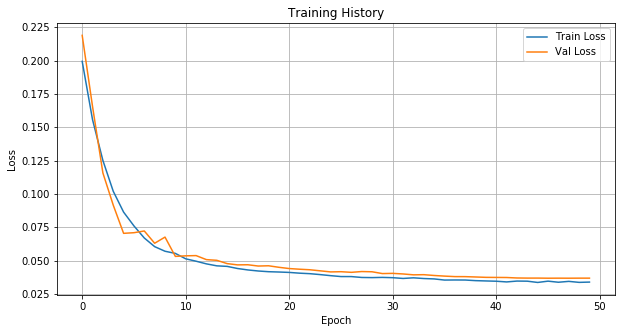

Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 3, 256, 256])
Encoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 16, 16])
Decoder:

torch.Size([8, 64, 256, 256])
torch.Size([8, 128, 128, 128])
torch.Size([8, 256, 64, 64])
torch.Size([8, 512, 32, 32])
torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8,

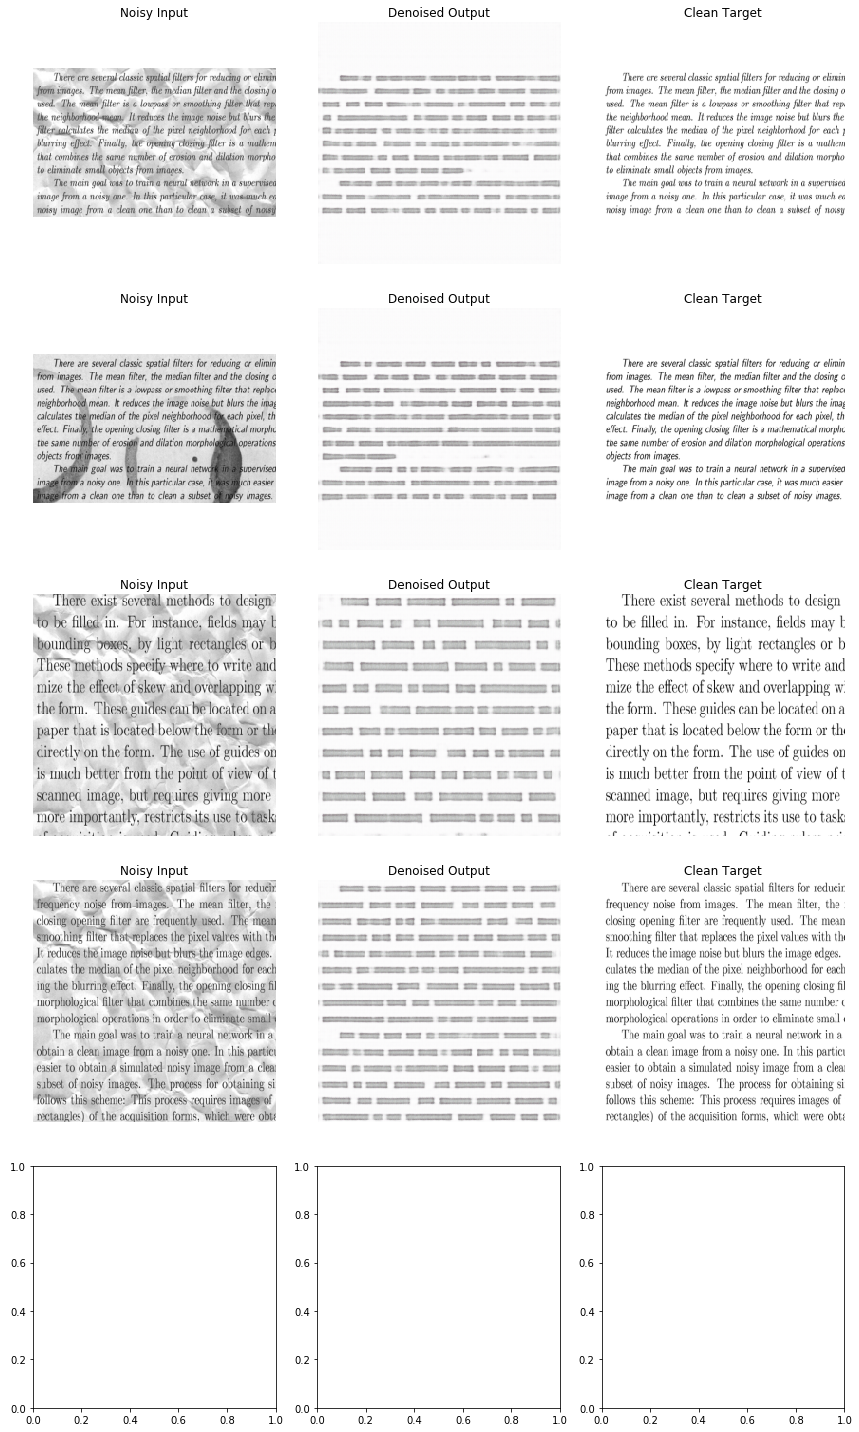


Training setup complete!

Key components:
1. ImagePreprocessor - handles resizing, normalization, augmentation
2. DenoisingDataset - custom dataset with preprocessing
3. Encoder-Decoder Architecture - classic autoencoder with skip connections
4. CombinedLoss - MSE + L1 for better quality
5. Trainer - complete training pipeline with cosine annealing


In [27]:
# ==================== MAIN USAGE EXAMPLE ====================

def main():
    # Configuration
    BATCH_SIZE = 8
    EPOCHS = 50
    LEARNING_RATE = 1e-3
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {DEVICE}")
    
    preprocessor = ImagePreprocessor(target_size=(256, 256))
    
    # Create datasets (80-20 train-val split)
    total_samples = len(train)
    train_split = int(0.8 * total_samples)
    
    train_dataset = DenoisingDataset(
        train[:train_split], 
        train_cleaned[:train_split], 
        preprocessor, 
        augment=True
    )
    
    val_dataset = DenoisingDataset(
        train[train_split:], 
        train_cleaned[train_split:], 
        preprocessor, 
        augment=False
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    # Create model
    model = DenoisingAutoencoder(use_skip_connections=False)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Create trainer
    trainer = Trainer(model, DEVICE, learning_rate=LEARNING_RATE)
    
    # Train model
    trainer.train(train_loader, val_loader, epochs=EPOCHS, save_path='best_denoising_model.pth')
    
    # Plot training history
    trainer.plot_training_history()
    
    # Visualize results
    trainer.visualize_results(val_loader, num_samples=5)
    
    print("\nTraining setup complete!")
    print("\nKey components:")
    print("1. ImagePreprocessor - handles resizing, normalization, augmentation")
    print("2. DenoisingDataset - custom dataset with preprocessing")
    print("3. Encoder-Decoder Architecture - classic autoencoder with skip connections")
    print("4. CombinedLoss - MSE + L1 for better quality")
    print("5. Trainer - complete training pipeline with cosine annealing")


if __name__ == "__main__":
    main()

In [26]:
!pip install --upgrade torch

    100% |████████████████████████████████| 881.9MB 49kB/s  eta 0:00:01  3% |█▎                              | 34.2MB 46.4MB/s eta 0:00:19    5% |█▋                              | 44.5MB 49.1MB/s eta 0:00:18    8% |██▋                             | 71.7MB 53.0MB/s eta 0:00:16    12% |████                            | 109.3MB 52.1MB/s eta 0:00:15    28% |█████████▎                      | 255.1MB 49.6MB/s eta 0:00:13    49% |████████████████                | 438.8MB 36.2MB/s eta 0:00:13    50% |████████████████                | 441.0MB 34.1MB/s eta 0:00:13    54% |█████████████████▍              | 479.5MB 50.8MB/s eta 0:00:08    56% |██████████████████              | 494.9MB 60.7MB/s eta 0:00:07    80% |█████████████████████████▉      | 711.8MB 45.7MB/s eta 0:00:04    81% |██████████████████████████▏     | 722.4MB 39.9MB/s eta 0:00:04    87% |████████████████████████████    | 773.6MB 58.0MB/s eta 0:00:02    92% |█████████████████████████████▋  | 817.3MB 48.8MB/s eta 0:00:02
  Found exist

In [27]:
from torch.optim import AdamW

ImportError: cannot import name 'AdamW'

In [28]:
import torch
print(torch.__version__)

1.0.0


In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(420, 540, 3,))) 
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.summary() 

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy"])


In [ ]:
model.fit(train, train_cleaned, epochs=500, batch_size=52, shuffle=True, validation_data=(train, train_cleaned))

In [ ]:
y_hat = model.predict_proba(test)

In [ ]:
y_hat = np.array(y_hat)
print(y_hat.shape)

    

In [ ]:
import matplotlib.pyplot as plt
for ima in y_hat:
    plt.figure()
    plt.imshow(ima)